# Plot Figures

In [ ]:
import msprime
import tsinfer
import tskit

import seaborn as sns
from IPython.display import SVG, display
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import numpy as np
import json
import collections
import time

In [113]:
# Import matched samples files

tgp_matched_samples = list()
for i in np.arange(1,23):
    tgp_matched_samples.append(tskit.load("matched_dataset_samples_augmented_ts/1kg_chr"+str(i)+"_matched_samples_augmented_ts.trees"))


In [114]:
ts = tskit.load("1kg_chr20.trees")

In [115]:
population_name = []
region_name = []

for population in ts.populations():
    md = json.loads(population.metadata.decode())
    if md["name"] != "Neolithic":
        name = md["name"]
        population_name.append(name)

reference_sets_map = collections.defaultdict(list)
population = []
region = []
individual = []
for j, u in enumerate(ts.individuals()):
    ind = json.loads(u.metadata.decode())
    if 'name' not in ind:
        for node in u.nodes:
            reference_sets_map[population_name[ts.node(node).population]].append(node) 

reference_set_names = list(reference_sets_map.keys())
reference_sets = [reference_sets_map[key] for key in reference_set_names]

ind_to_pop = {}
for j, u in enumerate(ts.samples()):
    node = ts.node(u)
    ind = json.loads(ts.individual(node.individual).metadata.decode())
    ind_to_pop[ind["individual_id"]] = node.population

In [117]:
def reference_sets_chr_tgp(matched_samples, ind_to_pop):
    reference_sets_map = collections.defaultdict(list)

    for j, u in enumerate(matched_samples.individuals()):
        ind = json.loads(u.metadata.decode())
        if 'name' not in ind:
            for node in u.nodes:
                reference_sets_map[population_name[ind_to_pop[ind["individual_id"]]]].append(node) 
                #population.append(population_name[node.population])
    reference_set_names = list(reference_sets_map.keys())
    reference_sets = [reference_sets_map[key] for key in reference_set_names]
    return(reference_sets)

In [120]:
# Load output saved above

A_tgp_ind0 = list()
A_tgp_ind1 = list()
for i in range(22):
    A_tgp_ind0.append(np.loadtxt('tgp_chr' + str(i+1) + '_ind0_mean_descendants.out'))
    A_tgp_ind1.append(np.loadtxt('tgp_chr' + str(i+1) + '_ind1_mean_descendants.out'))

In [121]:
# Normalize the two individual lists of A_tgp by reference set size

A_tgp_ref_set_normalized_ind0 = list()
A_tgp_ref_set_normalized_ind1 = list()

for chromo in range(len(A_tgp_ind0)):
    chromo_array_0 = np.zeros(A_tgp_ind0[chromo].shape)
    chromo_array_1 = np.zeros(A_tgp_ind1[chromo].shape)

    for index, (key, val) in enumerate(reference_sets_map.items()):
        chromo_array_0[index] = A_tgp_ind0[chromo][index]/len(val)
        chromo_array_1[index] = A_tgp_ind1[chromo][index]/len(val)
    A_tgp_ref_set_normalized_ind0.append(chromo_array_0)
    A_tgp_ref_set_normalized_ind1.append(chromo_array_1)


In [122]:
# Reweight by chromosome's proportion of total genome length
total_genome_length = 0
for chromo in tgp_matched_samples:
    total_genome_length += chromo.get_sequence_length()

A_tgp_ref_set_chr_length_readjusted_ind0 = list()
A_tgp_ref_set_chr_length_readjusted_ind1 = list()
for chromo in range(len(tgp_matched_samples)):
    chr_length = tgp_matched_samples[chromo].get_sequence_length()
    chr_reweighting = chr_length/total_genome_length
    A_tgp_ref_set_chr_length_readjusted_ind0.append(A_tgp_ref_set_normalized_ind0[chromo] * chr_reweighting)
    A_tgp_ref_set_chr_length_readjusted_ind1.append(A_tgp_ref_set_normalized_ind1[chromo] * chr_reweighting)

In [123]:
# Assign populations by continetnal grouping and then in descending order by number of descendants from the brothers

# Find the total amount of neolithic material inherited by each population over the autosomes
total_neolithic_0 = [A_tgp_ref_set_chr_length_readjusted_ind0[0][pop] for pop in range(26)]
total_neolithic_1 = [A_tgp_ref_set_chr_length_readjusted_ind1[0][pop] for pop in range(26)]

for i in np.arange(1,22):
    total_neolithic_0 = np.add(total_neolithic_0, [A_tgp_ref_set_chr_length_readjusted_ind0[i][pop] for pop in range(26)])
    total_neolithic_1 = np.add(total_neolithic_1, [A_tgp_ref_set_chr_length_readjusted_ind1[i][pop] for pop in range(26)])

combined_total_descendants = np.add(total_neolithic_0,total_neolithic_1)


In [124]:

pop_index = dict()
for idx, pop in enumerate(reference_set_names):
    pop_index[pop] = idx
all_chrs_combined_total_descendants = list()

for idx,val in zip(reference_set_names,combined_total_descendants):
    all_chrs_combined_total_descendants.append((idx,pop_index[idx],val))
ordered_descendants = sorted(all_chrs_combined_total_descendants, key=lambda x: x[2],reverse=True)
order = [pop[1] for pop in ordered_descendants]
reorder = [0,1,2,3,5,4,6,7,8,9,10,11,13,14,16,17,18,19,20,12,15,21,22,23,24,25]
reordered_descendants = [ordered_descendants[pop] for pop in reorder]
order = [pop[1] for pop in reordered_descendants]

In [125]:
ordered_descendants

[('IBS', 6, 0.008562665701015592),
 ('GBR', 0, 0.007424332196032526),
 ('CEU', 17, 0.007407246362928999),
 ('TSI', 24, 0.006998461868643875),
 ('PUR', 3, 0.003944467841748293),
 ('FIN', 1, 0.0038884653489375154),
 ('CLM', 5, 0.0037651241781604195),
 ('MXL', 23, 0.00358393131538802),
 ('PEL', 7, 0.002229843157091055),
 ('PJL', 8, 0.001702177366628338),
 ('BEB', 13, 0.0014276691905056997),
 ('GIH', 25, 0.0013688412194319073),
 ('ASW', 22, 0.0012888543850123001),
 ('ITU', 16, 0.001237751631824555),
 ('STU', 15, 0.0011423647215039528),
 ('ACB', 10, 0.0008329935942318582),
 ('KHV', 9, 0.0006996331571733209),
 ('CHB', 19, 0.0006069484132869002),
 ('JPT', 20, 0.0005751852422782109),
 ('CHS', 2, 0.000568521997385606),
 ('CDX', 4, 0.0005024666229482345),
 ('GWD', 11, 0.00037013484143928326),
 ('LWK', 21, 0.00035407822116062776),
 ('YRI', 18, 0.00024132586212927034),
 ('MSL', 14, 0.00018717809758571433),
 ('ESN', 12, 0.00018464197252538475)]

In [126]:
reordered_descendants

[('IBS', 6, 0.008562665701015592),
 ('GBR', 0, 0.007424332196032526),
 ('CEU', 17, 0.007407246362928999),
 ('TSI', 24, 0.006998461868643875),
 ('FIN', 1, 0.0038884653489375154),
 ('PUR', 3, 0.003944467841748293),
 ('CLM', 5, 0.0037651241781604195),
 ('MXL', 23, 0.00358393131538802),
 ('PEL', 7, 0.002229843157091055),
 ('PJL', 8, 0.001702177366628338),
 ('BEB', 13, 0.0014276691905056997),
 ('GIH', 25, 0.0013688412194319073),
 ('ITU', 16, 0.001237751631824555),
 ('STU', 15, 0.0011423647215039528),
 ('KHV', 9, 0.0006996331571733209),
 ('CHB', 19, 0.0006069484132869002),
 ('JPT', 20, 0.0005751852422782109),
 ('CHS', 2, 0.000568521997385606),
 ('CDX', 4, 0.0005024666229482345),
 ('ASW', 22, 0.0012888543850123001),
 ('ACB', 10, 0.0008329935942318582),
 ('GWD', 11, 0.00037013484143928326),
 ('LWK', 21, 0.00035407822116062776),
 ('YRI', 18, 0.00024132586212927034),
 ('MSL', 14, 0.00018717809758571433),
 ('ESN', 12, 0.00018464197252538475)]

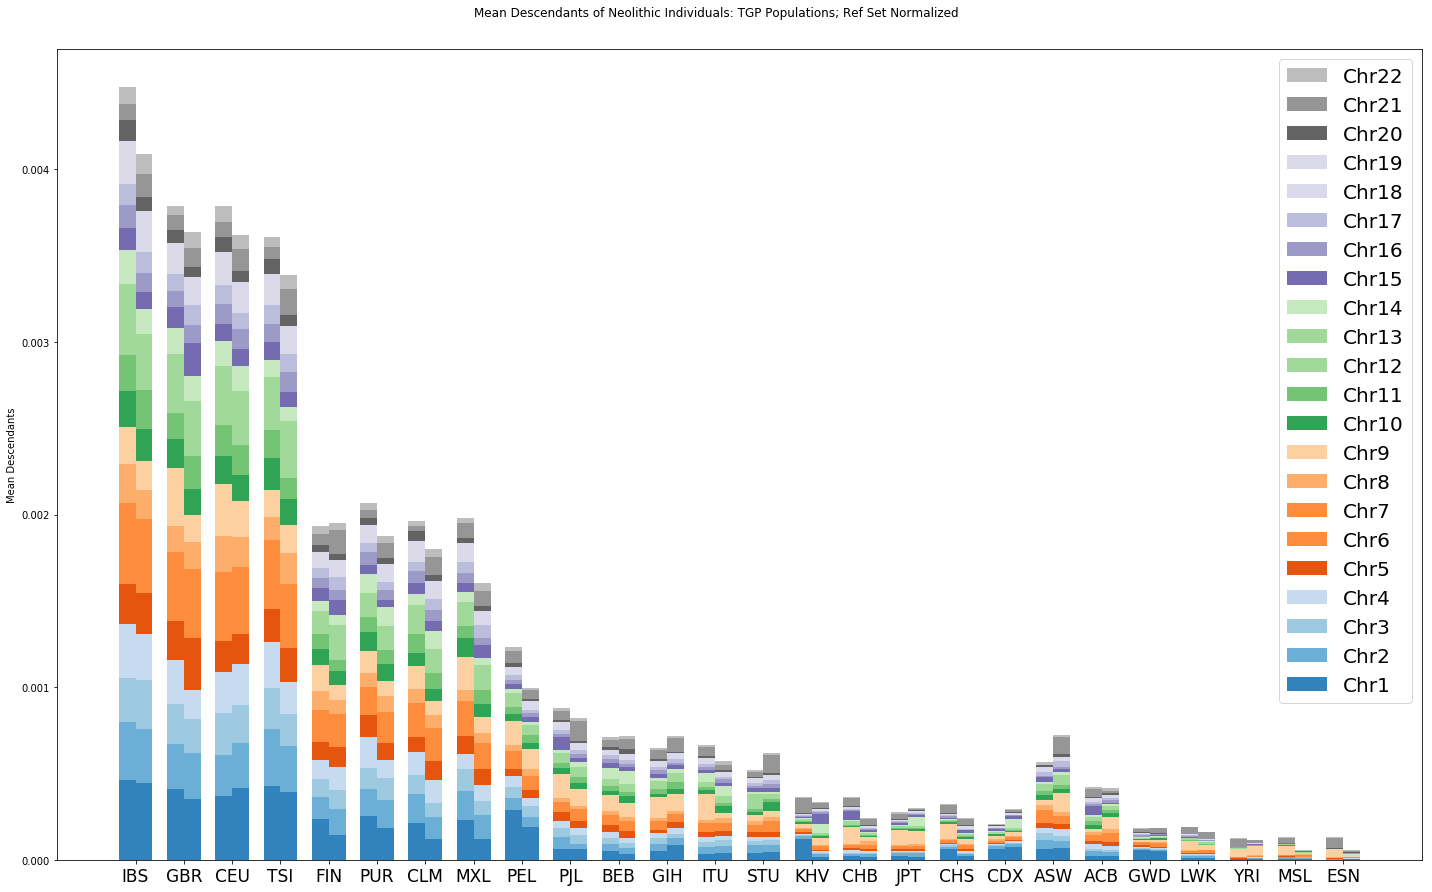

In [127]:
cmap = plt.cm.get_cmap('tab20c')
fig, ax = plt.subplots(figsize=(20,13))
fig.suptitle('Mean Descendants of Neolithic Individuals: TGP Populations; Ref Set Normalized')
width = 0.35

pops = np.arange(len(reference_set_names))
ax.bar(pops, [A_tgp_ref_set_chr_length_readjusted_ind0[0][pop] for pop in order], width = width, label = "Chr1", color=cmap(1/24))
ax.bar(pops + width, [A_tgp_ref_set_chr_length_readjusted_ind1[0][pop] for pop in order], width = width, color=cmap(1/24))
#bottom_0 = [chr_vals_0[pop] for pop in order]
#bottom_1 = [chr_vals_1[pop] for pop in order]
bottom_0 = [A_tgp_ref_set_chr_length_readjusted_ind0[0][pop] for pop in order]
bottom_1 = [A_tgp_ref_set_chr_length_readjusted_ind1[0][pop] for pop in order]

for i in np.arange(1,len(tgp_matched_samples)):
    ax.bar(pops, [A_tgp_ref_set_chr_length_readjusted_ind0[i][pop] for pop in order], width = width, color=cmap((i+1)/24), label = "Chr"+str(i+1), bottom = bottom_0)
    ax.bar(pops + width, [A_tgp_ref_set_chr_length_readjusted_ind1[i][pop] for pop in order], width = width, color=cmap((i+1)/24), bottom = bottom_1)
    
#     bottom_0 = np.add(bottom_0, [chr_vals_0[pop] for pop in order])
#     bottom_1 = np.add(bottom_1, [chr_vals_1[pop] for pop in order])
    bottom_0 = np.add(bottom_0, [A_tgp_ref_set_chr_length_readjusted_ind0[i][pop] for pop in order])
    bottom_1 = np.add(bottom_1, [A_tgp_ref_set_chr_length_readjusted_ind1[i][pop] for pop in order])

#plt.ylim(0,1e-7)
ax.set_xticks(pops + width / 2)  
ax.set_xticklabels([pop[0] for pop in reordered_descendants])
plt.xticks(fontsize=17)
plt.ylabel("Mean Descendants")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)
plt.savefig("tgp_augment_ancestors_mean_descendants_grouped_ref_set_fixed", dpi = 1000)

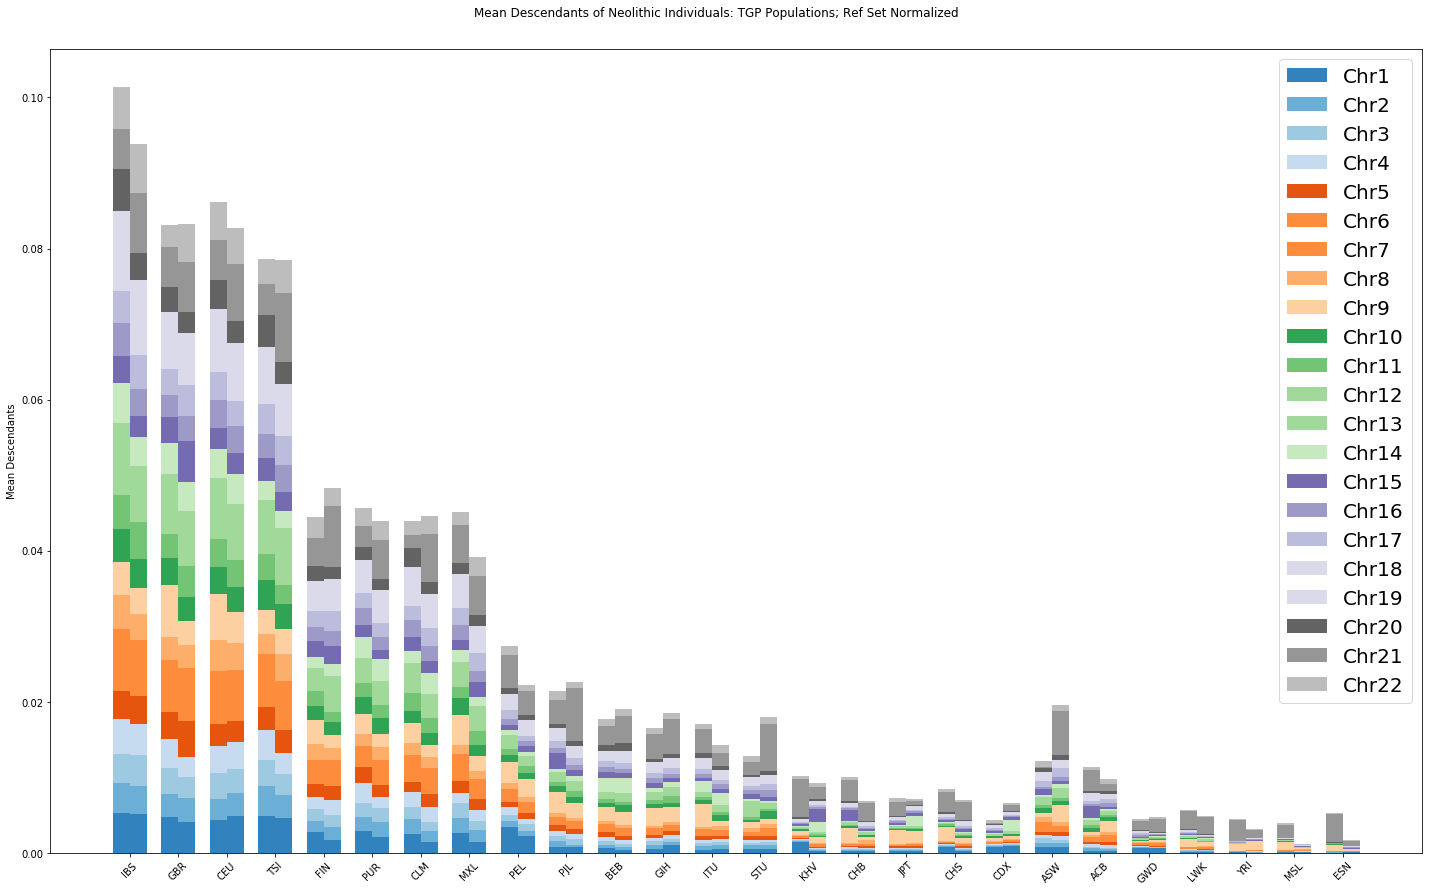

In [128]:
cmap = plt.cm.get_cmap('tab20c')
fig, ax = plt.subplots(figsize=(20,13))
fig.suptitle('Mean Descendants of Neolithic Individuals: TGP Populations; Ref Set Normalized')
width = 0.35

pops = np.arange(len(reference_set_names))
ax.bar(pops, [A_tgp_ref_set_normalized_ind0[0][pop] for pop in order], width = width, label = "Chr1", color=cmap(1/24))
ax.bar(pops + width, [A_tgp_ref_set_normalized_ind1[0][pop] for pop in order], width = width, color=cmap(1/24))
#bottom_0 = [chr_vals_0[pop] for pop in order]
#bottom_1 = [chr_vals_1[pop] for pop in order]
bottom_0_not_readjusted = [A_tgp_ref_set_normalized_ind0[0][pop] for pop in order]
bottom_1_not_readjusted = [A_tgp_ref_set_normalized_ind1[0][pop] for pop in order]

for i in np.arange(1,len(tgp_matched_samples)):
    ax.bar(pops, [A_tgp_ref_set_normalized_ind0[i][pop] for pop in order], width = width, color=cmap((i+1)/24), label = "Chr"+str(i+1), bottom = bottom_0_not_readjusted)
    ax.bar(pops + width, [A_tgp_ref_set_normalized_ind1[i][pop] for pop in order], width = width, color=cmap((i+1)/24), bottom = bottom_1_not_readjusted)
    
#     bottom_0 = np.add(bottom_0, [chr_vals_0[pop] for pop in order])
#     bottom_1 = np.add(bottom_1, [chr_vals_1[pop] for pop in order])
    bottom_0_not_readjusted = np.add(bottom_0_not_readjusted, [A_tgp_ref_set_normalized_ind0[i][pop] for pop in order])
    bottom_1_not_readjusted = np.add(bottom_1_not_readjusted, [A_tgp_ref_set_normalized_ind1[i][pop] for pop in order])

#plt.ylim(0,1e-7)
ax.set_xticks(pops + width / 2)  
ax.set_xticklabels([pop[0] for pop in reordered_descendants])
plt.xticks(rotation=45)
plt.ylabel("Mean Descendants")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend(prop={'size': 20})
#plt.savefig("tgp_augment_ancestors_mean_descendants_grouped_ref_set_fixed", dpi = 1000)

In [129]:
# Calculate the value for each chromosome scaled by total bar height
bottom_0

array([0.00447518, 0.00378736, 0.00378541, 0.00361095, 0.00193678,
       0.00206741, 0.00196542, 0.00198039, 0.00123222, 0.00088116,
       0.00071158, 0.00065028, 0.00066722, 0.00052141, 0.00036265,
       0.00036295, 0.00027455, 0.00032365, 0.00020946, 0.00056583,
       0.00041945, 0.00018353, 0.00019177, 0.00012435, 0.00013242,
       0.00013008])

In [130]:
bottom_0_not_readjusted

array([0.10137326, 0.08317121, 0.08612216, 0.07863194, 0.04448627,
       0.04569791, 0.04391649, 0.045083  , 0.02740438, 0.02140175,
       0.01770843, 0.01650163, 0.01701403, 0.01277198, 0.01016984,
       0.00998553, 0.00719814, 0.00842611, 0.00439465, 0.01215023,
       0.01136962, 0.00448819, 0.00561291, 0.00449905, 0.00391834,
       0.00520944])

In [131]:
proportions_0 = dict()
proportions_1 = dict()

for i in range(22):
    proportions_0[i] = bottom_0 * ([A_tgp_ref_set_normalized_ind0[i][pop] for pop in order]/bottom_0_not_readjusted)
    proportions_1[i] = bottom_1 * ([A_tgp_ref_set_normalized_ind1[i][pop] for pop in order]/bottom_1_not_readjusted)

In [132]:
proportions_0[0]

array([2.34479893e-04, 2.16379253e-04, 1.89201133e-04, 2.26297463e-04,
       1.19295932e-04, 1.32507823e-04, 1.08865129e-04, 1.15696281e-04,
       1.51008854e-04, 3.08952233e-05, 2.34977539e-05, 2.21460351e-05,
       1.46018468e-05, 1.91525427e-05, 5.04558742e-05, 9.17571817e-06,
       8.94153080e-06, 2.88759808e-05, 3.48159511e-05, 3.49395619e-05,
       9.43709007e-06, 2.67625412e-05, 3.46617153e-06, 1.19468450e-06,
       2.52438889e-06, 4.14637365e-07])

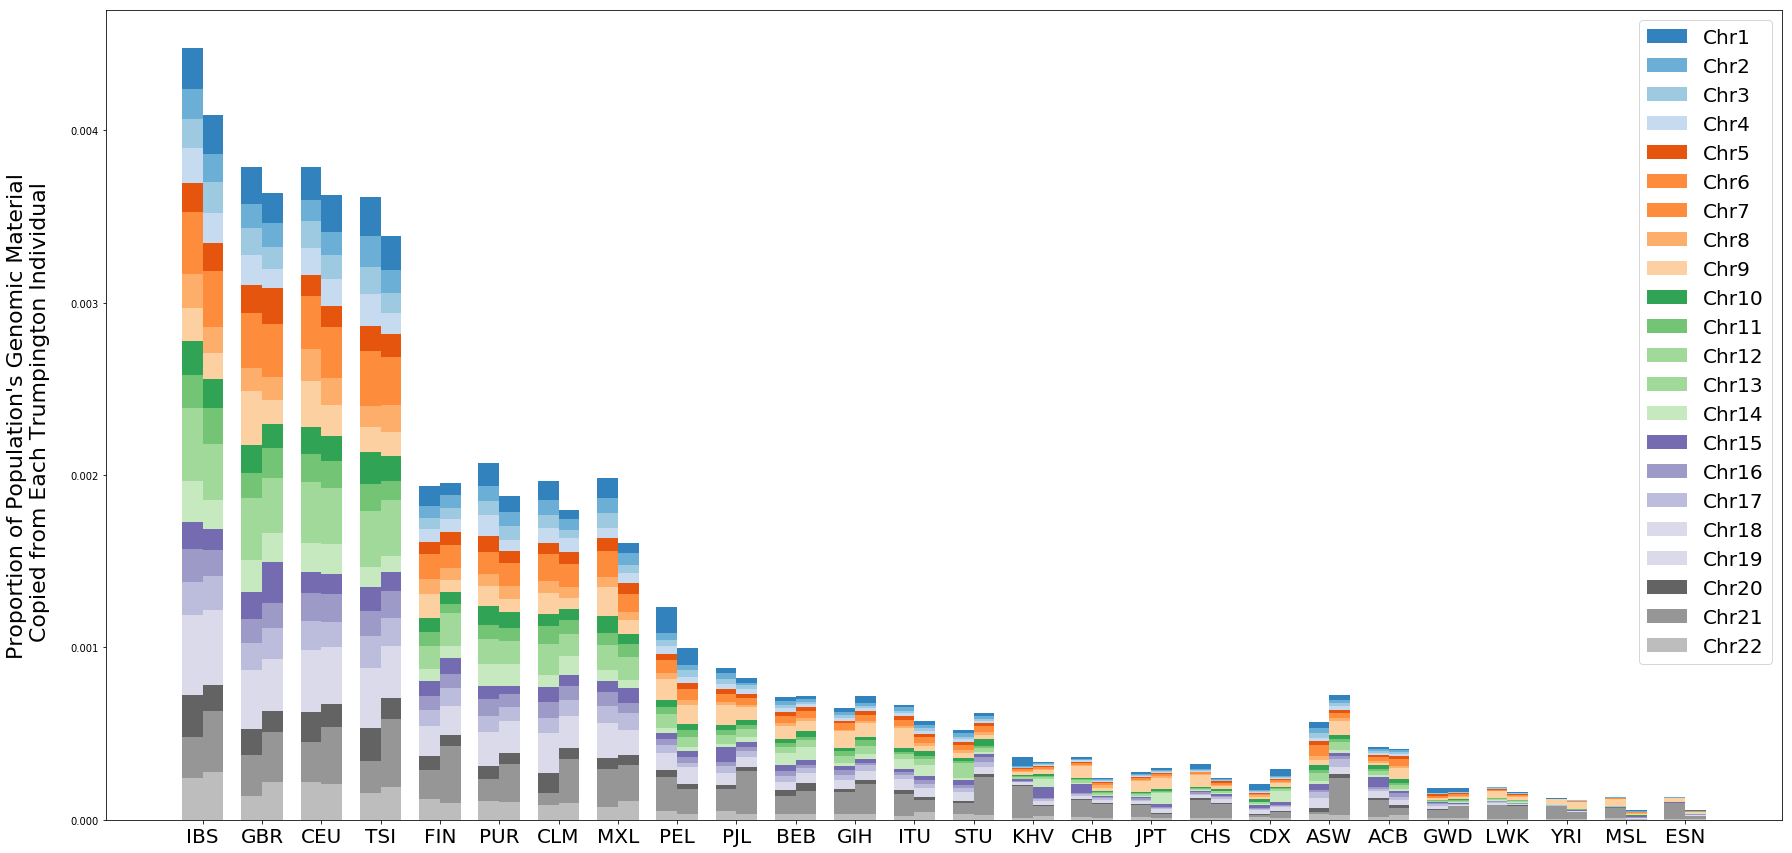

In [134]:
cmap = plt.cm.get_cmap('tab20c')
fig, ax = plt.subplots(figsize=(25,13))
#fig.suptitle('Mean Descendants of Neolithic Individuals: TGP Populations; Ref Set Normalized')
width = 0.35

pops = np.arange(len(reference_set_names))
ax.bar(pops, [proportions_0[21][pop] for pop in range(len(order))], width = width, label = "Chr22", color=cmap(22/24))
ax.bar(pops + width, [proportions_1[21][pop] for pop in range(len(order))], width = width, color=cmap(22/24))
#bottom_0 = [chr_vals_0[pop] for pop in order]
#bottom_1 = [chr_vals_1[pop] for pop in order]
bottom_0_not_readjusted = [proportions_0[21][pop] for pop in range(len(order))]
bottom_1_not_readjusted = [proportions_1[21][pop] for pop in range(len(order))]

for i in reversed(np.arange(0,len(tgp_matched_samples)-1)):
    ax.bar(pops, [proportions_0[i][pop] for pop in range(len(order))], width = width, color=cmap((i+1)/24), label = "Chr"+str(i+1), bottom = bottom_0_not_readjusted)
    ax.bar(pops + width, [proportions_1[i][pop] for pop in range(len(order))], width = width, color=cmap((i+1)/24), bottom = bottom_1_not_readjusted)
    
#     bottom_0 = np.add(bottom_0, [chr_vals_0[pop] for pop in order])
#     bottom_1 = np.add(bottom_1, [chr_vals_1[pop] for pop in order])
    bottom_0_not_readjusted = np.add(bottom_0_not_readjusted, [proportions_0[i][pop] for pop in range(len(order))])
    bottom_1_not_readjusted = np.add(bottom_1_not_readjusted, [proportions_1[i][pop] for pop in range(len(order))])

#plt.ylim(0,1e-7)
ax.set_xticks(pops + width / 2)  
ax.set_xticklabels([pop[0] for pop in reordered_descendants])
plt.xticks(fontsize=20)
plt.ylabel("Proportion of Population's Genomic Material\n Copied from Each Trumpington Individual", fontsize=22, labelpad=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)
plt.savefig("tgp_total_height_bar_proportions", dpi = 1000)

# SGDP

In [135]:
sgdp_matched_samples = list()
for i in np.arange(1,23):
    sgdp_matched_samples.append(tskit.load("matched_dataset_samples_augmented_ts/sgdp_chr"+str(i)+"_matched_samples_augmented_ts.trees"))


In [136]:
ts = tskit.load("sgdp_chr22.nosimplify.trees")
population_name = []
region_name = []

for population in ts.populations():
    md = json.loads(population.metadata.decode())
    if md["name"] != "Neolithic":
        name = md["name"]
        population_name.append(name)    
        region_name.append(md["region"])     

reference_sets_map = collections.defaultdict(list)
population = []
region = []
individual = []
for j, u in enumerate(ts.individuals()):
    ind = json.loads(u.metadata.decode())
    if 'name' not in ind:
        for node in u.nodes:
            reference_sets_map[population_name[ts.node(node).population]].append(node) 

reference_set_names = list(reference_sets_map.keys())
reference_sets = [reference_sets_map[key] for key in reference_set_names]

ind_to_pop = {}
for j, u in enumerate(ts.samples()):
    node = ts.node(u)
    ind = json.loads(ts.individual(node.individual).metadata.decode())
    ind_to_pop[ind["sample_id"]] = node.population

In [137]:
def reference_sets_chr_sgdp(matched_samples, ind_to_pop):
    reference_sets_map = collections.defaultdict(list)

    for j, u in enumerate(matched_samples.individuals()):
        ind = json.loads(u.metadata.decode())
        if 'name' not in ind:
            for node in u.nodes:
                reference_sets_map[population_name[ind_to_pop[ind["sample_id"]]]].append(node) 
                #population.append(population_name[node.population])
    reference_set_names = list(reference_sets_map.keys())
    reference_sets = [reference_sets_map[key] for key in reference_set_names]
    return(reference_sets)

In [139]:
A_sgdp_ind0 = list()
A_sgdp_ind1 = list()
for i in np.arange(0,22):
    A_sgdp_ind0.append(np.loadtxt('sgdp_chr' + str(i+1) + '_ind0_mean_descendants.out'))
    A_sgdp_ind1.append(np.loadtxt('sgdp_chr' + str(i+1) + '_ind1_mean_descendants.out'))

In [140]:
# For normalizing the two individual lists of A_sgdp
A_sgdp_ref_set_normalized_ind0 = list()
A_sgdp_ref_set_normalized_ind1 = list()

for chromo in range(len(A_sgdp_ind0)):
    chromo_array_0 = np.zeros(A_sgdp_ind0[chromo].shape)
    chromo_array_1 = np.zeros(A_sgdp_ind1[chromo].shape)

    for index, (key, val) in enumerate(reference_sets_map.items()):
        chromo_array_0[index] = A_sgdp_ind0[chromo][index]/len(val)
        chromo_array_1[index] = A_sgdp_ind1[chromo][index]/len(val)
    A_sgdp_ref_set_normalized_ind0.append(chromo_array_0)
    A_sgdp_ref_set_normalized_ind1.append(chromo_array_1)


In [141]:
# Reweight by chromosome length
total_genome_length = 0
for chromo in sgdp_matched_samples:
    total_genome_length += chromo.get_sequence_length()

A_sgdp_ref_set_chr_length_readjusted_ind0 = list()
A_sgdp_ref_set_chr_length_readjusted_ind1 = list()
for chromo in range(len(sgdp_matched_samples)):
    chr_length = sgdp_matched_samples[chromo].get_sequence_length()
    chr_reweighting = chr_length/total_genome_length
    A_sgdp_ref_set_chr_length_readjusted_ind0.append(A_sgdp_ref_set_normalized_ind0[chromo] * chr_reweighting)
    A_sgdp_ref_set_chr_length_readjusted_ind1.append(A_sgdp_ref_set_normalized_ind1[chromo] * chr_reweighting)

In [142]:
# This code orders the populations in descending order by number of descendants

bottom_0 = [A_sgdp_ref_set_chr_length_readjusted_ind0[0][pop] for pop in range(len(A_sgdp_ref_set_chr_length_readjusted_ind0[0]))]
bottom_1 = [A_sgdp_ref_set_chr_length_readjusted_ind1[0][pop] for pop in range(len(A_sgdp_ref_set_chr_length_readjusted_ind1[0]))]

for i in np.arange(1,len(sgdp_matched_samples)):
    bottom_0 = np.add(bottom_0, [A_sgdp_ref_set_chr_length_readjusted_ind0[i][pop] for pop in range(len(A_sgdp_ref_set_chr_length_readjusted_ind0[0]))])

for i in np.arange(1,len(sgdp_matched_samples)):
    bottom_1 = np.add(bottom_1, [A_sgdp_ref_set_chr_length_readjusted_ind1[i][pop] for pop in range(len(A_sgdp_ref_set_chr_length_readjusted_ind1[0]))])

combined_total_descendants = np.add(bottom_0,bottom_1)
pop_index = dict()
for idx, pop in enumerate(reference_set_names):
    pop_index[pop] = idx
all_chrs_combined_total_descendants = list()

for idx,val in zip(reference_set_names,combined_total_descendants):
    all_chrs_combined_total_descendants.append((idx,pop_index[idx],val))
ordered_descendants = sorted(all_chrs_combined_total_descendants, key=lambda x: x[2],reverse=True)
order = [pop[1] for pop in ordered_descendants]
#reorder = [0,1,2,3,5,4,6,7,9,8,10,11,12,13,16,17,18,19,22,14,15,20,21,23,24,25]
# reordered_descendants = [ordered_descendants[pop] for pop in reorder]
# order = [pop[1] for pop in reordered_descendants]


In [143]:
sgdp_metadata = pd.read_csv('sgdp_metadata.txt', encoding = "ISO-8859-1", sep = '\t')
ordered_descendants_df = pd.DataFrame(ordered_descendants)
reordered_regions = dict()
for region in sgdp_metadata.groupby("Region"):
    print(region[0])
    reordered_regions[region[0]] = ordered_descendants_df[ordered_descendants_df[0].isin(region[1]['Population_ID'])].sort_values(by=[2],ascending=False)   
    print(np.mean(ordered_descendants_df[ordered_descendants_df[0].isin(region[1]['Population_ID'])][2]))
    
    

Africa
0.006063656191028974
America
0.0035677831009198434
CentralAsiaSiberia
0.009721338585040469
EastAsia
0.006216176203465759
Oceania
0.008943965909371266
SouthAsia
0.0153527761317514
WestEurasia
0.035480946332865554


In [144]:
super_pop_order = ["WestEurasia","SouthAsia","CentralAsiaSiberia","Oceania","EastAsia","America","Africa"]
ordered_pop_list = [descendant[0] for descendant in ordered_descendants]
reordered = list()
for superpop in super_pop_order:
    for index, population_id in reordered_regions[superpop].iterrows():
        reordered.append(ordered_pop_list.index(population_id[0]))

In [145]:
reordered_descendants = [ordered_descendants[pop] for pop in reordered]
order = [pop[1] for pop in reordered_descendants]


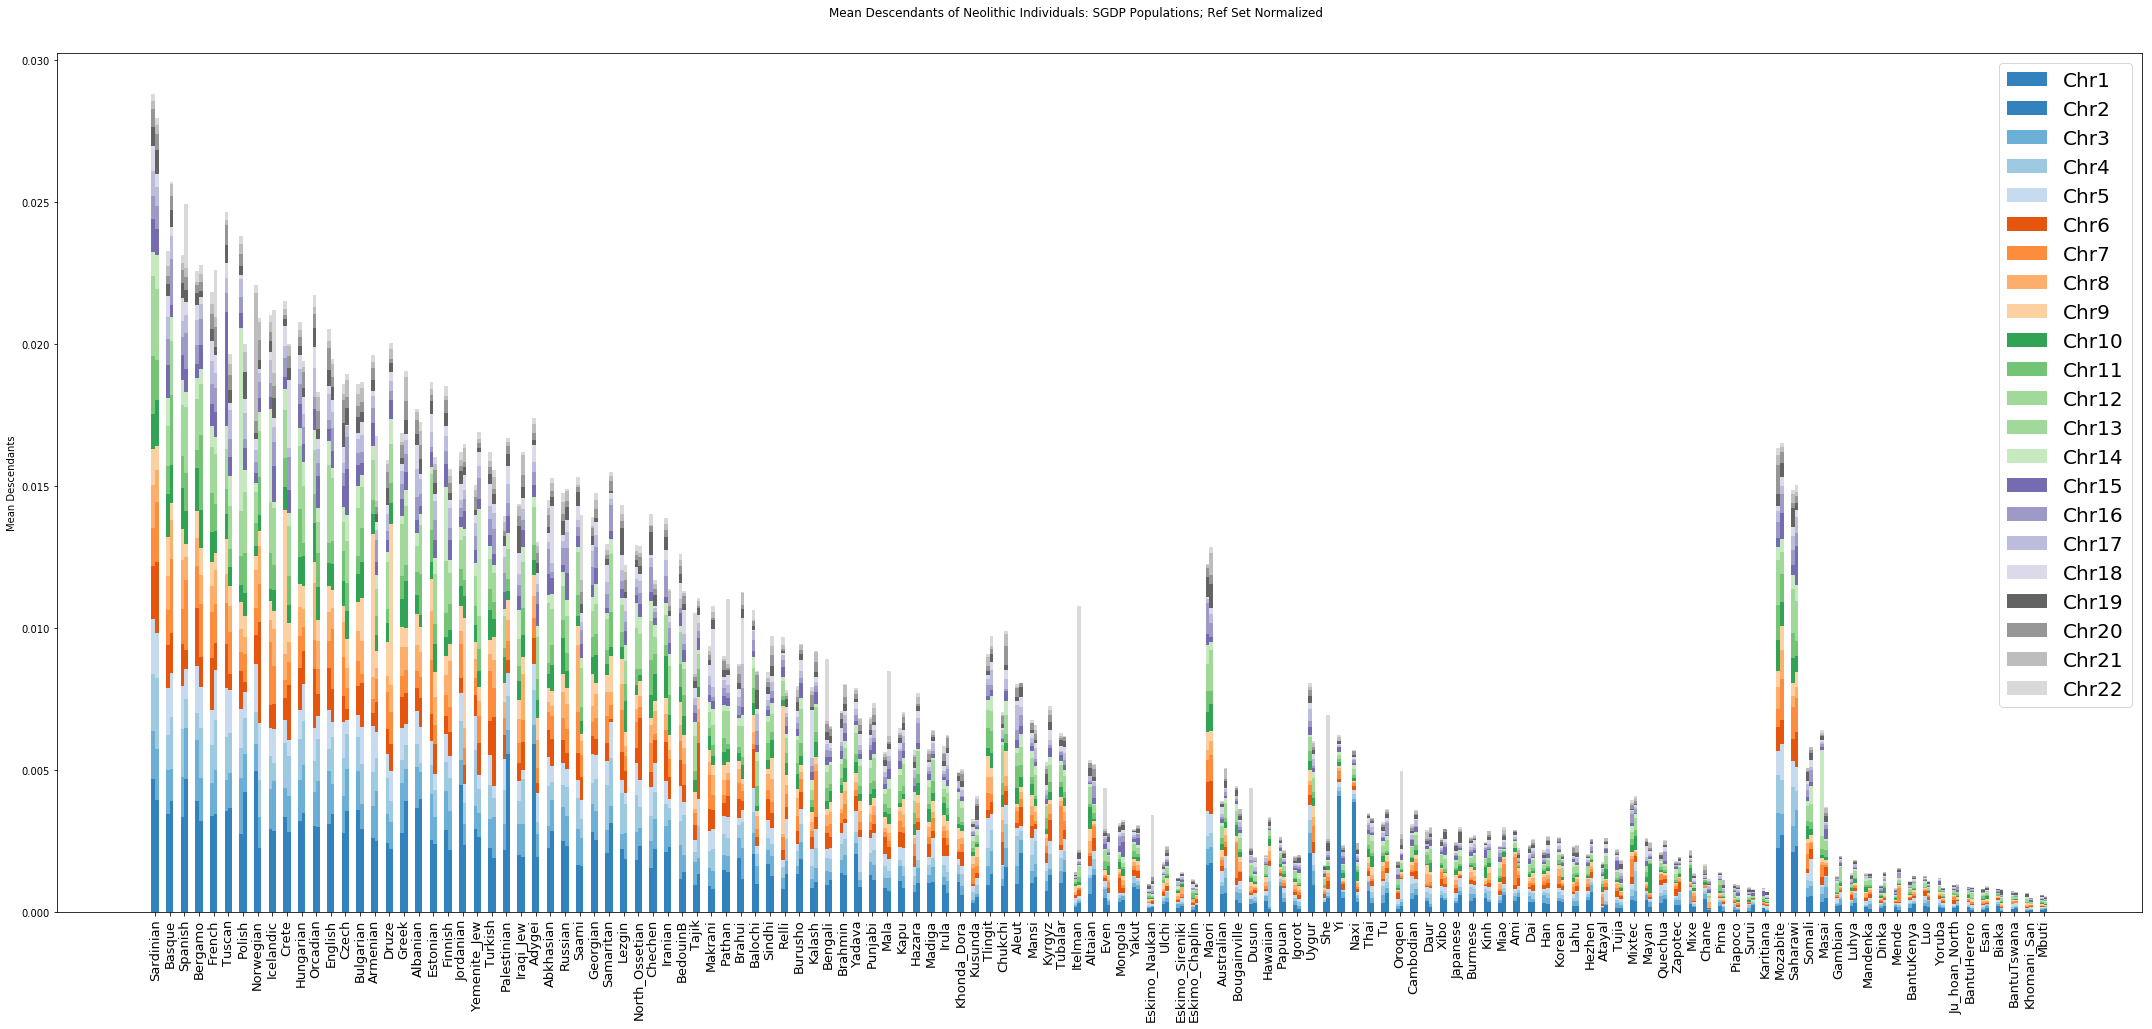

In [146]:
# This is a plot of mean descendants normalized by ref set size (not by chromosome size relative to total genome size)
cmap = plt.cm.get_cmap('tab20c')
fig, ax = plt.subplots(figsize=(30,15))
fig.suptitle('Mean Descendants of Neolithic Individuals: SGDP Populations; Ref Set Normalized')
width = 0.25

pops = np.arange(len(reference_set_names))
ax.bar(pops, [A_sgdp_ref_set_chr_length_readjusted_ind0[0][pop] for pop in order], width = width, label = "Chr1", color=cmap(0))
ax.bar(pops + width, [A_sgdp_ref_set_chr_length_readjusted_ind1[0][pop] for pop in order], width = width, color=cmap(0))
#bottom_0 = [chr_vals_0[pop] for pop in order]
#bottom_1 = [chr_vals_1[pop] for pop in order]
bottom_0 = [A_sgdp_ref_set_chr_length_readjusted_ind0[0][pop] for pop in order]
bottom_1 = [A_sgdp_ref_set_chr_length_readjusted_ind1[0][pop] for pop in order]

for i in np.arange(1,len(sgdp_matched_samples)):
    ax.bar(pops, [A_sgdp_ref_set_chr_length_readjusted_ind0[i][pop] for pop in order], width = width, color=cmap(i/22), label = "Chr"+str(i+1), bottom = bottom_0)
    ax.bar(pops + width, [A_sgdp_ref_set_chr_length_readjusted_ind1[i][pop] for pop in order], width = width, color=cmap(i/22), bottom = bottom_1)
    
#     bottom_0 = np.add(bottom_0, [chr_vals_0[pop] for pop in order])
#     bottom_1 = np.add(bottom_1, [chr_vals_1[pop] for pop in order])
    bottom_0 = np.add(bottom_0, [A_sgdp_ref_set_chr_length_readjusted_ind0[i][pop] for pop in order])
    bottom_1 = np.add(bottom_1, [A_sgdp_ref_set_chr_length_readjusted_ind1[i][pop] for pop in order])

#plt.ylim(0,1e-7)
ax.set_xticks(pops + width / 2)  
ax.set_xticklabels([pop[0] for pop in reordered_descendants])
plt.xticks(fontsize=13,rotation=90)
plt.ylabel("Mean Descendants")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend(prop={'size': 20})
#plt.savefig("sgdp_augment_ancestors_mean_descendants_grouped_ref_set_fixed", dpi = 1000)

In [147]:
# Find the total amount of neolithic material inherited by each population over the autosomes
total_neolithic_0 = [A_sgdp_ref_set_normalized_ind0[0][pop] for pop in order]
total_neolithic_1 = [A_sgdp_ref_set_normalized_ind1[0][pop] for pop in order]

for i in np.arange(1,22):
    total_neolithic_0 = np.add(total_neolithic_0, [A_sgdp_ref_set_normalized_ind0[i][pop] for pop in order])
    total_neolithic_1 = np.add(total_neolithic_1, [A_sgdp_ref_set_normalized_ind1[i][pop] for pop in order])


In [148]:
proportions_0 = dict()
proportions_1 = dict()
for i in range(22):
    proportions_0[i] = bottom_0 * ([A_sgdp_ref_set_normalized_ind0[i][pop] for pop in order]/total_neolithic_0)
    proportions_1[i] = bottom_1 * ([A_sgdp_ref_set_normalized_ind1[i][pop] for pop in order]/total_neolithic_1)

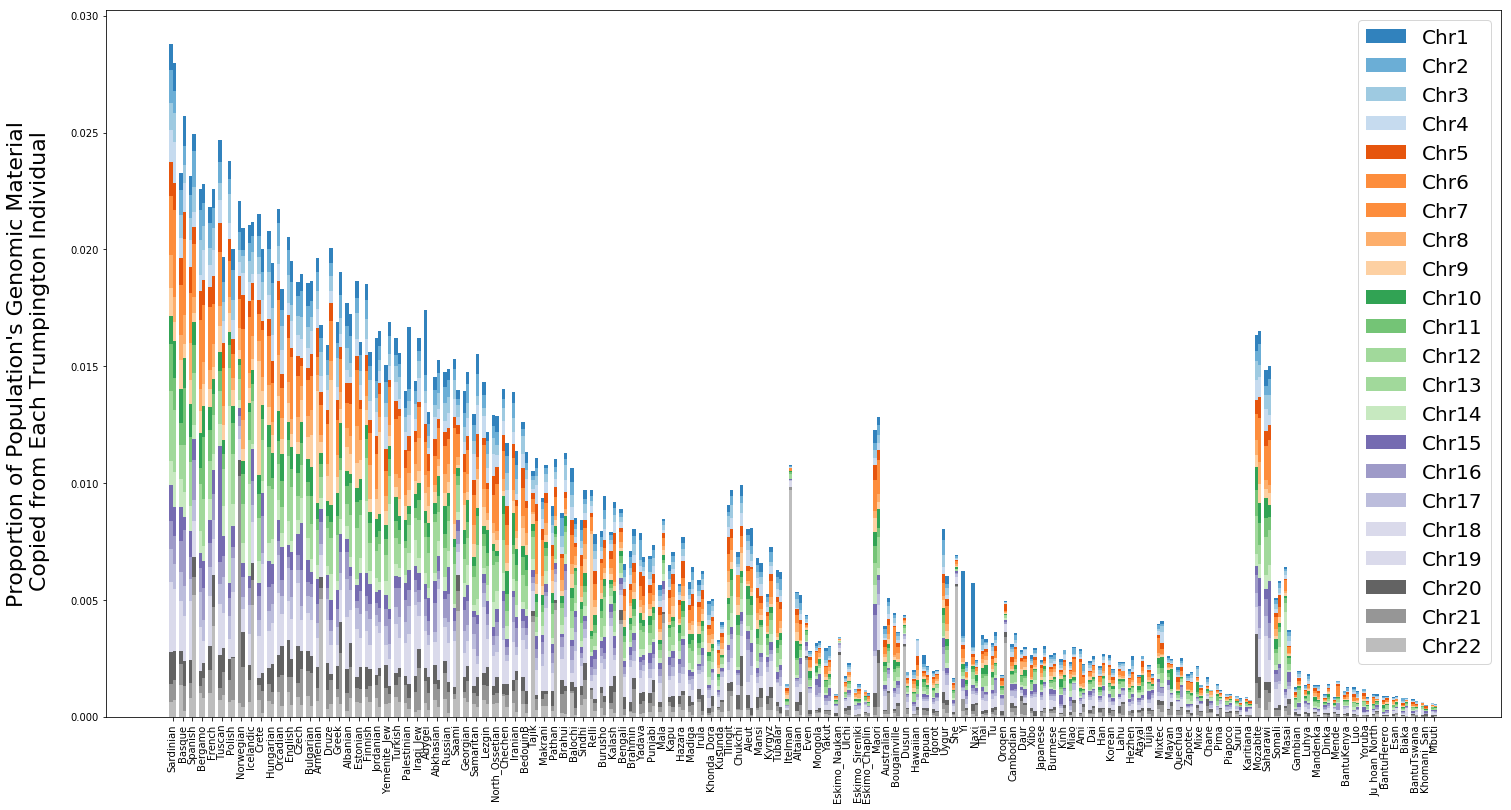

In [149]:
cmap = plt.cm.get_cmap('tab20c')
fig, ax = plt.subplots(figsize=(25,13))
#fig.suptitle('Mean Descendants of Neolithic Individuals: SGDP Populations; Total Length with stacked bars indicating un-genome-normalized')
width = 0.35

pops = np.arange(len(reference_set_names))
ax.bar(pops, [proportions_0[21][pop] for pop in range(len(order))], width = width, label = "Chr22", color=cmap(22/24))
ax.bar(pops + width, [proportions_1[21][pop] for pop in range(len(order))], width = width, color=cmap(22/24))
#bottom_0 = [chr_vals_0[pop] for pop in order]
#bottom_1 = [chr_vals_1[pop] for pop in order]
bottom_0_not_readjusted = [proportions_0[21][pop] for pop in range(len(order))]
bottom_1_not_readjusted = [proportions_1[21][pop] for pop in range(len(order))]

for i in reversed(np.arange(0,len(tgp_matched_samples)-1)):
    ax.bar(pops, [proportions_0[i][pop] for pop in range(len(order))], width = width, color=cmap((i+1)/24), label = "Chr"+str(i+1), bottom = bottom_0_not_readjusted)
    ax.bar(pops + width, [proportions_1[i][pop] for pop in range(len(order))], width = width, color=cmap((i+1)/24), bottom = bottom_1_not_readjusted)
    
#     bottom_0 = np.add(bottom_0, [chr_vals_0[pop] for pop in order])
#     bottom_1 = np.add(bottom_1, [chr_vals_1[pop] for pop in order])
    bottom_0_not_readjusted = np.add(bottom_0_not_readjusted, [proportions_0[i][pop] for pop in range(len(order))])
    bottom_1_not_readjusted = np.add(bottom_1_not_readjusted, [proportions_1[i][pop] for pop in range(len(order))])

#plt.ylim(0,1e-7)
ax.set_xticks(pops + width / 2)  
ax.set_xticklabels([pop[0] for pop in reordered_descendants])
plt.xticks(fontsize=10,rotation=90)
plt.ylabel("Proportion of Population's Genomic Material\n Copied from Each Trumpington Individual", fontsize=22, labelpad=20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=20)
plt.savefig("sgdp_total_height_bar_proportions", dpi = 1000)